# Analysis and visualization of 3D data in Python

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Analysis and visualization of 3D data in Python_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite
software](preparation.md) beforehand.

For more info:
  * [[ISVC 2019]](https://www.isvc.net/)
  * [[scikit-image]](https://scikit-image.org/)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

%matplotlib inline

In [5]:
from skimage import io  # skimage's I/O submodule.
from skimage import data

In [6]:
input_filename="data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

In [ ]:
#!wget https://github.com/dani-lbnl/imagexd19/blob/master/dip/data/bead_pack.tif?raw=true

In [ ]:
#!mv bead_pack.tif?raw=true bead_pack.tif

In [ ]:
#!ls *.tif

In [ ]:
#img = io.imread('bead_pack.tif')

## Basic image summary

In [4]:
print('* Shape: {}'.format(img.shape))
print('* Type: {}'.format(img.dtype))
print('* Range: {}, {}'.format(img.min(), img.max()))

* Shape: (200, 200, 200)
* Type: uint8
* Range: 29, 239


## Skim through

In [5]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

def slicer(z):
    plt.imshow(img[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=5,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

In [6]:
#Equalization for volume data, although you might be skiming through your data 
from skimage import exposure
ex = exposure.equalize_hist(img)
def slicer(z):
    plt.imshow(ex[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=5,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

In [7]:
#Find the edges of an image using the Laplace operator
from skimage import filters
img2 = filters.laplace(img)
def slicer(z):
    plt.imshow(img2[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

interactive(children=(IntSlider(value=5, description='z', max=60), Output()), _dom_classes=('widget-interact',…

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 1152x720 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1215f9588>,
       dtype=object))

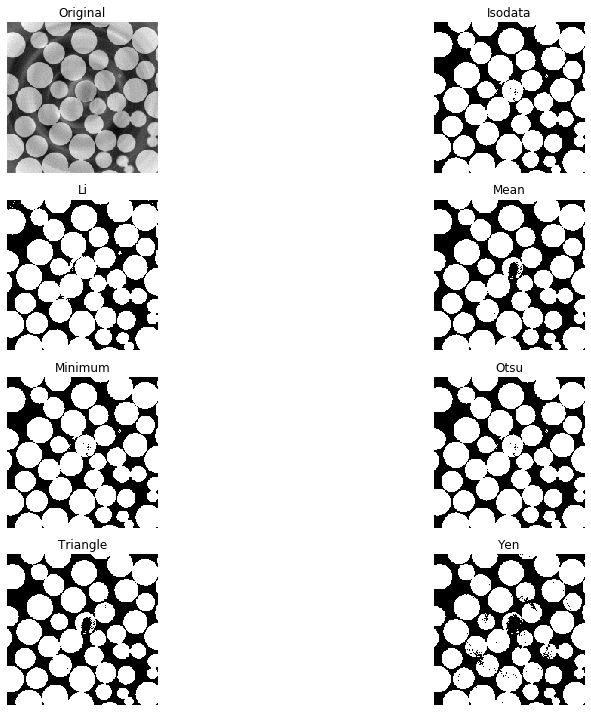

In [19]:
from skimage import filters
n=27
aslice = img[n,:,:]
filters.try_all_threshold(aslice,figsize=(16,10))

In [16]:
from skimage import filters
img3 = filters.gaussian(img)
t=filters.threshold_isodata(img3)
img3 = img3>t

def slicer(z):
    plt.imshow(img3[z,:,:], cmap='gray')

interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

NameError: name 'interact' is not defined

In [10]:
# skimage's morphological submodules.
from skimage import morphology  

In [11]:
ball = morphology.ball(radius=3)

In [12]:
#3D Mathematical morphology
img2te=morphology.binary_erosion(img3,selem=ball)
img2to=morphology.binary_opening(img3,selem=ball)

In [13]:
#show two 2D images side by side for quick comparison
def imshowcmp(before,after,lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

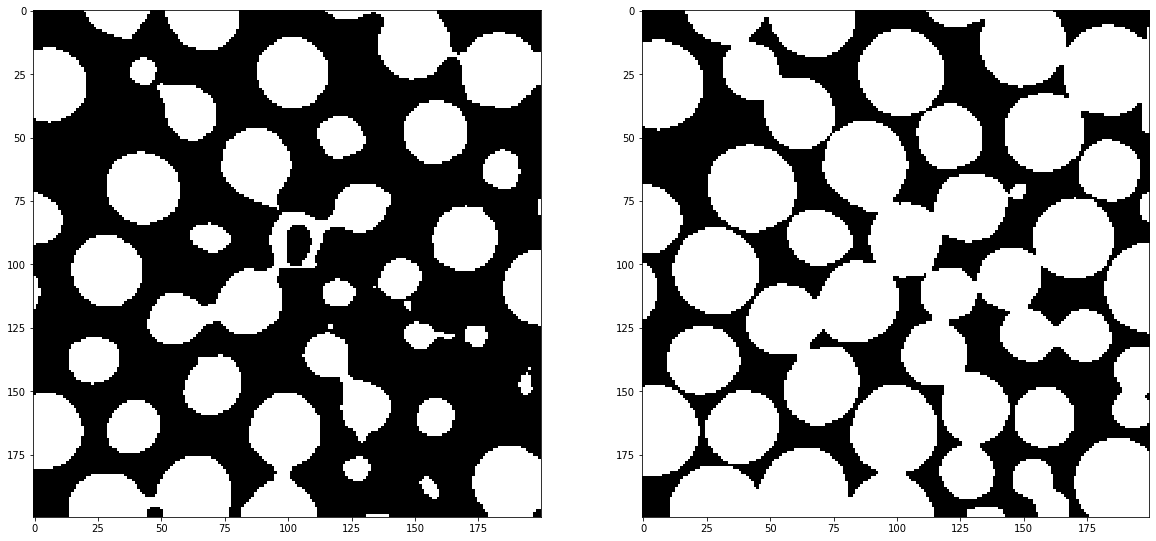

In [14]:
imshowcmp(img2te[n,:,:],img2to[n,:,:],'gray')

In [21]:
binary=morphology.binary_erosion(img2to,selem=ball)

In [ ]:
a = binary
def slicer(z):
    plt.imshow(a[z,:,:], cmap='gray')
interact(slicer, z=widgets.IntSlider(min=0,max=60,step=1,value=5));

In general, there's some much one can segment using only classical filters and thresholding. A complete investigation will often include machine learning methods using unsupervised and supervised classification of voxels.

## Supervised classification using markers

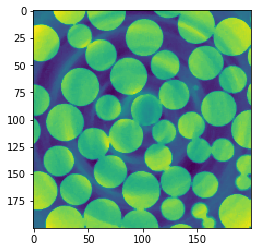

In [20]:
from skimage import segmentation as seg
b = filters.median(aslice)
plt.imshow(b)

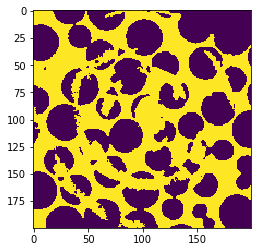

In [16]:
seed_point = (10, 10)  # Experiment with the seed point
c = seg.flood(b, seed_point, tolerance=50)
plt.imshow(c)

## Unsupervised - kmeans

In [30]:
np.min(b)

51

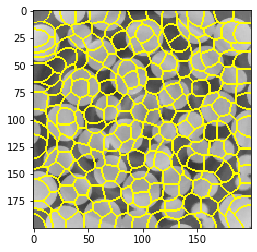

In [55]:
from skimage.segmentation import slic, mark_boundaries
from skimage import restoration
aslice = restoration.denoise_bilateral(b, multichannel=False)
segments = slic(aslice, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=500, multichannel=False) #higher compact = more weight space, more square
plt.imshow(mark_boundaries(b, segments))

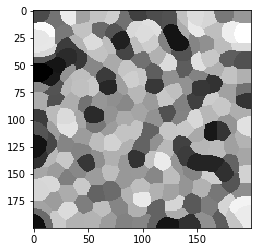

In [56]:
from skimage import color
from skimage.future import graph
output = color.label2rgb(segments, aslice, kind='avg')
plt.imshow(output,cmap='gray')

In [ ]:
from skimage import filters
volFilt = filters.gaussian(img)
segments = slic(volFilt, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=50, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, volFilt, kind='avg')

In [67]:
import itk
from itkwidgets import view

In [69]:
image_itk = itk.GetImageFromArray(binary.astype(np.uint8))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)

NameError: name 'binary' is not defined

In [ ]:
from skimage import feature, measure

In [ ]:
label = measure.label(binary)
regions = measure.regionprops(label,intensity_image=img)

In [ ]:
np.max(label) #len(regionprops)

In [ ]:
#all_props = {p:regions[0][p] for p in regions[0] if p not in ('image','convex_image','filled_image')}
for p in regions:
    print(p.area)

In [ ]:
image_itk = itk.GetImageFromArray(label.astype(np.uint16))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)

## How about some deep learning?

- Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years.
- Inception-v3 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is **48** layers deep and can classify images into **1000 object** categories, such as keyboard, mouse, pencil, and many animals.
- There are a total of 1,281,167 images for training. The number of images for each synset (category) ranges from 732 to 1300. There are 50,000 validation images, with 50 images per synset. There are 100,000 test images.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions

In [ ]:
net = InceptionV3()

**Why is it so fast?** We used transfer learning, a machine learning method which utilizes a pre-trained neural network. For example, the image recognition model called Inception-v3 consists of two parts: 
- Feature extraction part with a convolutional neural network;
- Classification part with fully-connected and softmax layers.

In [ ]:
from skimage import transform

def inception_predict(image):
    # Rescale image to 299x299, as required by InceptionV3
    image_prep = transform.resize(image, (299, 299, 3), mode='reflect')
    
    # Scale image values to [-1, 1], as required by InceptionV3
    image_prep = (img_as_float(image_prep) - 0.5) * 2
    
    predictions = decode_predictions(
        net.predict(image_prep[None, ...])
    )
    
    plt.imshow(image, cmap='gray')
    
    for pred in predictions[0]:
        (n, klass, prob) = pred
        print(f'{klass:>15} ({prob:.3f})')



In [ ]:
from skimage import data, img_as_float
inception_predict(data.chelsea())

In [ ]:
inception_predict(data.camera())